In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
engine

Engine(sqlite:///Resources/hawaii.sqlite)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
for table_name in inspector.get_table_names():
    for column in inspector.get_columns(table_name):
        print(table_name, column.get("name"), column.get("type"))

measurement id INTEGER
measurement station TEXT
measurement date TEXT
measurement prcp FLOAT
measurement tobs FLOAT
station id INTEGER
station station TEXT
station name TEXT
station latitude FLOAT
station longitude FLOAT
station elevation FLOAT


In [12]:
#last data point in the database
last_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [13]:
# Calculate the date 1 year ago from the last date
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print (year_ago)

2016-08-23


In [14]:
# Perform a query to retrieve the data and precipitation scores
rain_scores = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date > year_ago).\
    order_by(Measurement.date).all()
rain_scores[:5]

[('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22)]

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
rain_scores_DF = pd.DataFrame(rain_scores, columns=['date', 'prcp'])
rain_scores_DF[:5]

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [16]:
# Sort the dataframe by date
rain_scores_DF.set_index('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


<Figure size 360x288 with 0 Axes>

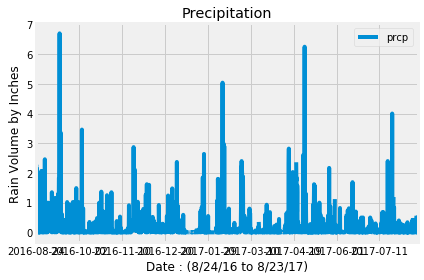

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
fig1 = plt.figure(figsize=(5,4))
rain_scores_DF.plot('date', 'prcp')
plt.grid(True)
plt.xlabel("Date : (8/24/16 to 8/23/17)")
plt.ylabel("Rain Volume by Inches")
plt.title("Precipitation")
plt.legend()
plt.tight_layout()
plt.show()
plt.close(fig1)

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_scores_DF.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [50]:
# Design a query to show how many stations are available in this dataset?
stations_count= session.query(Measurement).group_by(Measurement.station).count()
stations_count

9

In [49]:
stations_query = session.query(Station.name, Station.station)
stations = pd.read_sql(stations_query.statement, stations_query.session.bind)
stations

,name,station
0,"WAIKIKI 717.2, HI US",USC00519397
1,"KANEOHE 838.1, HI US",USC00513117
2,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830
3,"PEARL CITY, HI US",USC00517948
4,"UPPER WAHIAWA 874.3, HI US",USC00518838
5,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523
6,"WAIHEE 837.5, HI US",USC00519281
7,"HONOLULU OBSERVATORY 702.2, HI US",USC00511918
8,"MANOA LYON ARBO 785.2, HI US",USC00516128


In [51]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
 order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
best_station = active_stations [0][0]
session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station == best_station).all()

[(54.0, 71.66378066378067, 85.0)]

In [30]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_info = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == best_station).\
                filter(Measurement.date >= year_ago).all()
temp_df = pd.DataFrame(temp_info)
temp_df.set_index('station', inplace=True)
temp_df.head()

,tobs
station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0


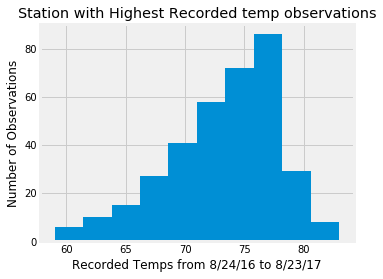

In [37]:
# plot the results as a histogram
fig2 = plt.figure(figsize=(5,4))
plt.grid(True)
temp_df = pd.DataFrame(temp_info)
plt.hist(temp_df['tobs'])
bin_size = 12
plt.xlabel("Recorded Temps from 8/24/16 to 8/23/17")
plt.ylabel("Number of Observations")
plt.title("Station with Highest Recorded temp observations")
plt.show()

In [38]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """

    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [40]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps('2017-07-02', '2017-07-08')
trip

[(71.0, 78.11904761904762, 87.0)]

In [42]:
trip_df = pd.DataFrame(trip, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
trip_df

,Min Temp,Avg Temp,Max Temp
0,71.0,78.119048,87.0


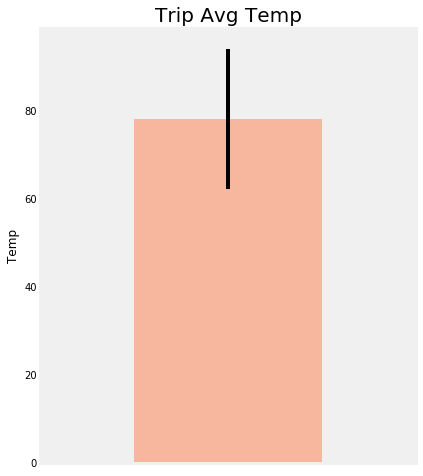

In [45]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp")
plt.xticks([])
plt.grid()
plt.show()
